In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/portscan-real/attack_portscan (1).csv
/kaggle/input/portscan/attack_portscan.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv


In [2]:

import os, json, time, gc, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import PowerTransformer


import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, BatchNormalization,
                                     SpatialDropout1D, Dropout, Dense, LSTM,
                                     Bidirectional, GlobalAveragePooling1D,
                                     LayerNormalization)
from tensorflow.keras.layers import MultiHeadAttention, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# reproducibility
SEED = 42

2026-02-06 09:04:47.545219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770368687.782263      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770368687.856226      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770368688.438216      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770368688.438258      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770368688.438261      55 computation_placer.cc:177] computation placer alr

In [4]:
paths = [
    "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv"
]




In [5]:
def load_concat(paths):
    dfs = []
    for p in paths:
        temp = pd.read_csv(p, low_memory=False)
        temp.columns = temp.columns.str.strip()
        dfs.append(temp)

    df = pd.concat(dfs, ignore_index=True, copy=False)
    return df

In [6]:
def preprocess(df):
    dfc = df.copy()
    dfc.columns = dfc.columns.str.strip()
    FEATURES = [
    "Flow Duration",
    "Total Fwd Packets",
    "Total Backward Packets",
    "Total Length of Fwd Packets",
    "Total Length of Bwd Packets",

    "Fwd Packet Length Min",
    "Fwd Packet Length Max",
    "Fwd Packet Length Mean",
    "Fwd Packet Length Std",

    "Bwd Packet Length Min",
    "Bwd Packet Length Max",
    "Bwd Packet Length Mean",
    "Bwd Packet Length Std",

    "Flow Bytes/s",
    "Flow Packets/s",

    "Flow IAT Mean",
    "Flow IAT Std",
    "Fwd IAT Mean",
    "Fwd IAT Std",
    "Bwd IAT Mean",
    "Bwd IAT Std",

    "Min Packet Length",
    "Max Packet Length",
    "Packet Length Mean",
    "Packet Length Std",
    "Packet Length Variance",

    "FIN Flag Count",
    "SYN Flag Count",
    "RST Flag Count",
    "PSH Flag Count",
    "ACK Flag Count",
    "URG Flag Count",
    "ECE Flag Count",

    "Fwd PSH Flags",
    "Bwd PSH Flags",
    "Fwd URG Flags",
    "Bwd URG Flags",

    "Down/Up Ratio",

    "Average Packet Size",
    "Avg Fwd Segment Size",
    "Avg Bwd Segment Size",

    "Active Mean",
    "Active Std",
    "Idle Mean",
    "Idle Std"
]

    LABEL = "Label"
    df_selected = dfc[FEATURES + [LABEL]]
    df_selected["Label"] = (df_selected["Label"].astype(str).str.strip().str.lower()
                    .replace({"normal": "benign"}))
    y = df_selected["Label"]
    X = df_selected.drop(columns=["Label"])
    X = X.apply(pd.to_numeric, errors="coerce")
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)
    
    df_clean = pd.concat([X, y], axis=1)
    return df_clean
    print("Final shape:", df_clean.shape)
    print("Columns kept:", df_clean.columns.tolist())



In [8]:
def normalize_label(s: str) -> str:
    s = str(s).lower().strip()
    s = (s.replace('web attack –', 'web attack -')
           .replace('web attack —', 'web attack -')
           .replace('web attack �', 'web attack -'))
    if s == 'benign':
        return 'benign'
    if 'web attack' in s or 'xss' in s or 'sql injection' in s:
        return 'webattack'
    if any(k in s for k in ['hulk', 'goldeneye', 'slowloris', 'slowhttptest']):
        return 'dos'
    if 'ddos' in s:
        return 'ddos'
    if any(k in s for k in ['ftp-patator', 'ssh-patator']):
        return 'bruteforce'
    if 'portscan' in s or 'port scan' in s:
        return 'portscan'
    if 'bot' in s:
        return 'bot'
    if 'infiltration' in s:
        return 'infiltration'
    return s


In [9]:
df_raw = load_concat(paths)
df = preprocess(df_raw)
df["Label"] = df["Label"].astype(str).map(normalize_label)
print("After clean:", df.shape)
print(df["Label"].value_counts())

After clean: (2830743, 46)
Label
benign          2273097
dos              252661
portscan         158930
ddos             128027
bruteforce        13835
webattack          2180
bot                1966
infiltration         36
heartbleed           11
Name: count, dtype: int64


In [10]:
print("Columns kept:", df.columns.tolist())

Columns kept: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Min', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Mean', 'Bwd IAT Std', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Active Mean', 'Active Std', 'Idle Mean', 'Idle Std', 'Label']


In [11]:
import os

ART_DIR = "./artifacts"
os.makedirs(ART_DIR, exist_ok=True)


In [12]:
BENIGN_CAP = 400_000
ATTACK_CAP = 600_000

df_bal1 = (
    df.groupby("Label", group_keys=False)
      .apply(
          lambda x: x.sample(
              n=min(
                  len(x),
                  BENIGN_CAP if x.name == "benign" else ATTACK_CAP
              ),
              random_state=SEED
          )
      )
      .reset_index(drop=True)
)

df_bal1["binary_label"] = df_bal1["Label"].apply(
    lambda x: 0 if x == "benign" else 1
)


In [13]:

X = df_bal1.drop(columns=["Label", "binary_label"])
y = df_bal1["binary_label"] 

X_train, X_test, y_train_idx, y_test_idx = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print( X_train.shape, X_test.shape)
selector = VarianceThreshold(0.01)
X_train_sel = selector.fit_transform(X_train)
X_test_sel  = selector.transform(X_test)

scaler = PowerTransformer(method="yeo-johnson", standardize=True)
X_train_ml = scaler.fit_transform(X_train_sel)
X_test_ml  = scaler.transform(X_test_sel)
num_classes = 2
y_train_cnn = y_train_idx.values
y_test_cnn  = y_test_idx.values

X_train_cnn = X_train_ml[..., np.newaxis]
X_test_cnn  = X_test_ml[...,  np.newaxis]

cls = np.unique(y_train_idx)
cw_values = compute_class_weight(class_weight="balanced", classes=cls, y=y_train_idx)
class_weight = {int(c): float(w) for c, w in zip(cls, cw_values)}
print({"class_weight": class_weight})


joblib.dump(selector, os.path.join(ART_DIR, "selector0.pkl"))
joblib.dump(scaler,   os.path.join(ART_DIR, "scaler0.pkl"))


print(f"ML 2D  -> X_train: {X_train_ml.shape}, X_test: {X_test_ml.shape}")
print(f"CNN 3D -> X_train: {X_train_cnn.shape}, X_test: {X_test_cnn.shape}")
print(f"y_train (idx/oh): {y_train_idx.shape} / {y_train_cnn.shape}")

np.savez_compressed(
    os.path.join(ART_DIR, "prepared_train_test0.npz"),
    X_train_ml=X_train_ml, X_test_ml=X_test_ml,
    y_train_idx=y_train_idx, y_test_idx=y_test_idx,
    X_train_cnn=X_train_cnn, X_test_cnn=X_test_cnn,
    y_train_cnn=y_train_cnn, y_test_cnn=y_test_cnn,
)


(766116, 45) (191530, 45)
{'class_weight': {0: 1.19705625, 1: 0.8586511131633925}}
ML 2D  -> X_train: (766116, 40), X_test: (191530, 40)
CNN 3D -> X_train: (766116, 40, 1), X_test: (191530, 40, 1)
y_train (idx/oh): (766116,) / (766116,)


In [14]:
import tensorflow as tf

def binary_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        loss = -alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)

    return loss


In [15]:

timesteps = X_train_cnn.shape[1]
channels  = X_train_cnn.shape[2]
inputs = Input(shape=(timesteps, channels), name="inputs")

x = Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = SpatialDropout1D(0.2)(x)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(256, 3, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = SpatialDropout1D(0.2)(x)
x = MaxPooling1D(2, padding='same')(x)

x = Bidirectional(LSTM(128, return_sequences=True), name="bilstm")(x)
attn_out = MultiHeadAttention(num_heads=4, key_dim=64, name="mha")(x, x)
x = Add()([x, attn_out])                
x = LayerNormalization()(x)

x = GlobalAveragePooling1D(name="gap")(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid', name="output")(x)

attn_model = Model(inputs, outputs, name="CNN_BiLSTM_Attn_binary")
attn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=binary_focal_loss(alpha=0.25, gamma=2.0),
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="Precision"),
        tf.keras.metrics.Recall(name="Recall")
    ]
)


attn_model.summary()

I0000 00:00:1770369091.226322      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770369091.233861      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "CNN_BiLSTM_Attn_binary"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 40, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 40, 128)   │        512 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 40, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 40, 128)   │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20, 128)   │          0 │ spatial_dropout1… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 256)   │     98,560 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 20, 256)   │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 10, 256)   │          0 │ spatial_dropout1… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 10, 256)   │    394,240 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 10, 256)   │    263,168 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 256)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 256)   │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 256)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 791,553 (3.02 MB)

 Trainable params: 790,785 (3.02 MB)

 Non-trainable params: 768 (3.00 KB)

In [16]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_dataset = train_dataset.shuffle(len(X_train_cnn), seed=SEED)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_cnn))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


xb, yb = next(iter(train_dataset))
print("Sanity shapes:", xb.shape, yb.shape)
print("One forward:", attn_model(xb, training=False).shape)

Sanity shapes: (256, 40, 1) (256,)


I0000 00:00:1770369096.090060      55 cuda_dnn.cc:529] Loaded cuDNN version 91002


One forward: (256, 1)


In [19]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os


In [20]:
CKPT_PATH = os.path.join(ART_DIR, "best_model_binary.keras")

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        CKPT_PATH,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]


In [21]:
EPOCHS = 30

history = attn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/30
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Precision: 0.9447 - Recall: 0.8404 - accuracy: 0.8790 - loss: 0.0590
Epoch 1: val_loss improved from inf to 0.02836, saving model to ./artifacts/best_model_binary.keras
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 87s 26ms/step - Precision: 0.9448 - Recall: 0.8404 - accuracy: 0.8790 - loss: 0.0590 - val_Precision: 0.9831 - val_Recall: 0.9628 - val_accuracy: 0.9687 - val_loss: 0.0284 - learning_rate: 1.0000e-04
Epoch 2/30
2992/2993 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - Precision: 0.9847 - Recall: 0.9590 - accuracy: 0.9675 - loss: 0.0257
Epoch 2: val_loss improved from 0.02836 to 0.01595, saving model to ./artifacts/best_model_binary.keras
2993/2993 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - Precision: 0.9847 - Recall: 0.9590 - accuracy: 0.9675 - loss: 0.0257 - val_Precision: 0.9902 - val_Recall: 0.9588 - val_accuracy: 0.9705 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 3/30
2992/2993 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.9867 - Recal

In [22]:
best_model = tf.keras.models.load_model(
    CKPT_PATH,
    custom_objects={"loss": binary_focal_loss(alpha=0.25, gamma=2.0)}
)


In [23]:
y_prob = best_model.predict(val_dataset, verbose=1).ravel()
y_true = y_test_cnn


749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


In [30]:
y_pred_05 = (y_prob >= 0.4446967).astype(int)

cm = confusion_matrix(y_true, y_pred_05)
print(cm)


[[ 78576   1424]
 [  1505 110025]]


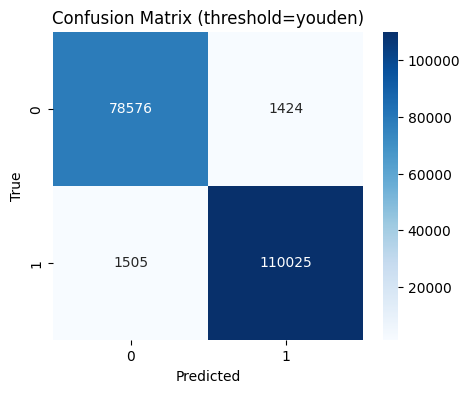

In [31]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (threshold=youden)")
plt.show()


In [33]:
print(classification_report(
    y_true,
    y_pred_05,
    target_names=["Benign", "Attack"]
))


              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98     80000
      Attack       0.99      0.99      0.99    111530

    accuracy                           0.98    191530
   macro avg       0.98      0.98      0.98    191530
weighted avg       0.98      0.98      0.98    191530



In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)


ROC AUC: 0.9987674906975702


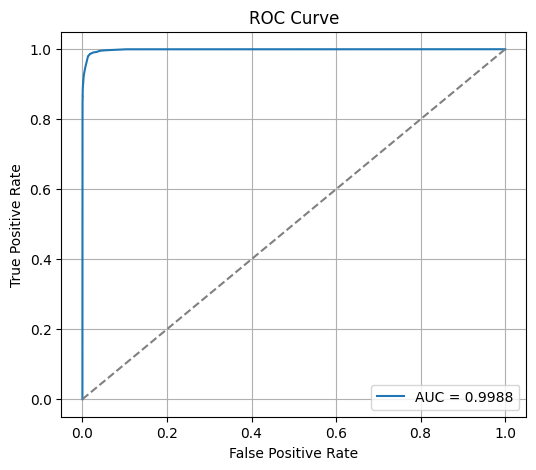

In [35]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)

best_threshold = thresholds[best_idx]
print("Best threshold (Youden):", best_threshold)


Best threshold (Youden): 0.4446967
